In [1]:
%autosave 0
from __future__ import absolute_import, division, print_function

Autosave disabled


# The YCrCb Color Space

In [1]:
%pylab inline
import cv2
from PIL import Image
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
# constants not defined in older OpenCV versions
cv2.COLOR_YCrCb2RGB = cv2.COLOR_YCR_CB2RGB
cv2.COLOR_RGB2YCrCb = cv2.COLOR_RGB2YCR_CB

## Transformation from RGB to YCrCb JPEG (or YCC)

$$
\begin{eqnarray*}
  Y   &=& 0.299 \cdot R + 0.587 \cdot G + 0.144 \cdot B \\
  C_r &=& 0.713 \cdot (R - Y) + 0.5 \\
      &=& 0.713 \cdot \big((1 - 0.299) \cdot R - 0.587 \cdot G - 0.144 \cdot B\big) + 0.5 \\
      &=& 0.5 \cdot R - 0.419 \cdot G - 0.081 \cdot B + 0.5\\
  C_b &=& 0.564 \cdot (B - Y) + 0.5 \\
      &=& 0.564 \cdot \big(-0.299 \cdot R - 0.586 \cdot G + (1-0.144) \cdot B \big) + 0.5 \\
      &=& -0.169 \cdot R - 0.331 \cdot G + 0.5 \cdot B + 0.5
\end{eqnarray*}
$$

$$
\begin{pmatrix}
Y \\ C_r \\ C_b
\end{pmatrix}
=
\begin{pmatrix}
 0.299 &  0.587 &  0.114 \\
 0.5   & -0.419 & -0.081 \\
-0.169 & -0.331 &  0.5
\end{pmatrix}
\cdot
\begin{pmatrix}
R \\ G \\ B
\end{pmatrix}
+
\begin{pmatrix}
0 \\ 0.5 \\ 0.5
\end{pmatrix}
$$

## Transformation from YCrCb JPEG to RGB

In [3]:
matRGB2YCrCb = np.mat([[0.299, 0.587, 0.114], [0.5, -0.419, - 0.081], [-0.169, -0.331, 0.5]])
matYCrCb2RGB = matRGB2YCrCb.I
matYCrCb2RGB

matrix([[  1.00000000e+00,   1.40168676e+00,  -9.26744840e-04],
        [  1.00000000e+00,  -7.14169040e-01,  -3.43695384e-01],
        [  1.00000000e+00,   9.90220514e-04,   1.77216042e+00]])

In [4]:
translYCrCb2RGB = matYCrCb2RGB * np.mat([0, -0.5, -0.5]).T
translYCrCb2RGB

matrix([[-0.70038001],
        [ 0.52893221],
        [-0.88657532]])

$$
\begin{eqnarray*}
  \begin{pmatrix}
    R \\ G \\ B
  \end{pmatrix}
  &=&
  \begin{pmatrix}
    1 &  1.403 &  0 \\
    1 & -0.714 & -0.344 \\
    1 &  0     &  1.773
  \end{pmatrix}
  \cdot
  \begin{pmatrix}
  Y \\ C_r - 0.5 \\ C_b - 0.5
  \end{pmatrix} \\
  &=&
  \begin{pmatrix}
    1 &  1.403 &  0 \\
    1 & -0.714 & -0.344 \\
    1 &  0     &  1.773
  \end{pmatrix}
  \cdot
  \begin{pmatrix}
  Y \\ C_r \\ C_b
  \end{pmatrix}
  \quad + \quad
  \begin{pmatrix}
    -0.7 \\ 0.529 \\ -0.887
  \end{pmatrix}
\end{eqnarray*}
$$

## Create Cb-Cr color planes for  different luma values Y

In [5]:
x, y = meshgrid(linspace(0,255,256), linspace(0,255,256));
img = zeros([256, 256, 3], dtype='uint8')
img[:,:,1] = 255-y   # Cr
img[:,:,2] = x       # Cb
lumas = [0, 0.5, 1]
color_planes = list();
for luma in lumas:
    img[:,:,0] = luma * 255
    color_plane = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB) # out-of-range RGB values are cropped!
    color_planes.append(color_plane)

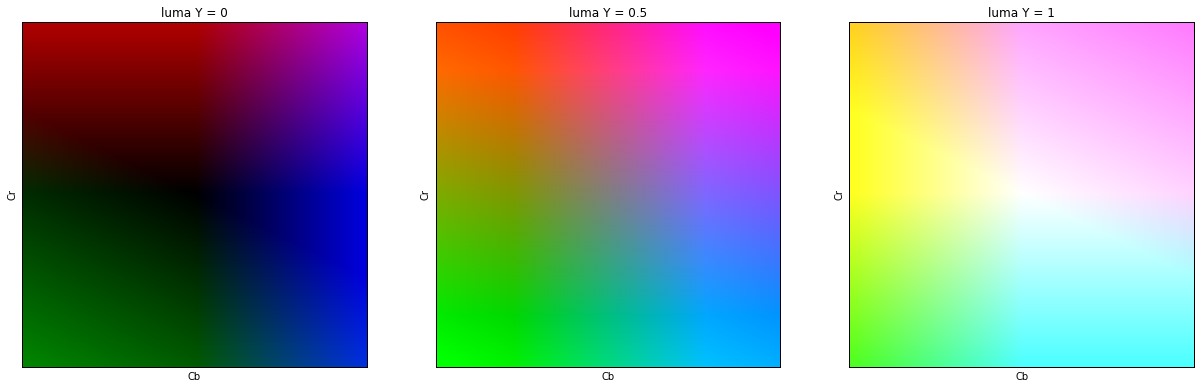

In [6]:
figure(figsize(21,7))
i = 0
for color_plane in color_planes:
    plt.subplot(1, 3, i+1), plt.imshow(color_plane)
    plt.xticks([]), plt.yticks([])
    plt.xlabel('Cb'), plt.ylabel('Cr')
    plt.title('luma Y = {0}'.format(lumas[i]))
    i += 1

### WARNING: not all combinations of Y, Cr, and Cb values are valid

These three Cb-Cr planes are misleading as they show RGB values for invalid combinations of Y, Cr, and Cb values.
The resulting out-of-range RGB values are cropped to the intensity range [0, 1] for each RGB channel.

If Y = 0, the R, G, and B values have to be 0. Consequently, Cr and Cb have to be 0.5. Hence, the Cb-Cr plane for Y=0 consists of just one black pixel  in the middle.

Along the same lines, if Y = 1, the R, G, and B values have to be 1. Again, Cr and Cb have to be 0.5; the Cb-Cr plane for Y = 1 consists of just one white pixel in the middle.

Invalid combinations of Y, Cr, and Cb values result in out-of-range RGB values. Next, instead of cropping RGB values, we will show invalid RGB values where at least one channel is out-of-range as gray pixels of intensity 0.2.

In [7]:
def mark_invalid_rgb_values(img, minimum=0, maximum=1, new_min_value=0.2, new_max_value=0.2):
    h, w, ch = img.shape
    for i in range(h):
        for j in range(w):
            rgb = img[i,j,:]
            if rgb[0] < minimum or rgb[1] < minimum or rgb[2] < minimum: 
                img[i,j,0] = img[i,j,1] = img[i,j,2] = new_min_value
            if rgb[0] > maximum or rgb[1] > maximum or rgb[2] > maximum:
                img[i,j,0] = img[i,j,1] = img[i,j,2] = new_max_value
    return img

In [8]:
x, y = meshgrid(linspace(0,255,256), linspace(0,255,256));
img = zeros([256, 256, 3], dtype='float32')
img[:,:,1] = (255-y) / 255.0   # Cr
img[:,:,2] = x / 255.0         # Cb
lumas = [0, .114, .299, .413, .587, .701, .886, 1]
# lumas = linspace(0, 1, 256)
color_planes = list();
for luma in lumas:
    img[:,:,0] = luma
    color_plane = mark_invalid_rgb_values(cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB))
    color_planes.append(color_plane)
    # img_save = color_plane * 255
    # img_save = img_save.astype(uint8)
    # filename = 'colorplane{num:03d}.png'.format(num=int(luma * 255 + .5))
    # Image.fromarray(img_save).save(filename)

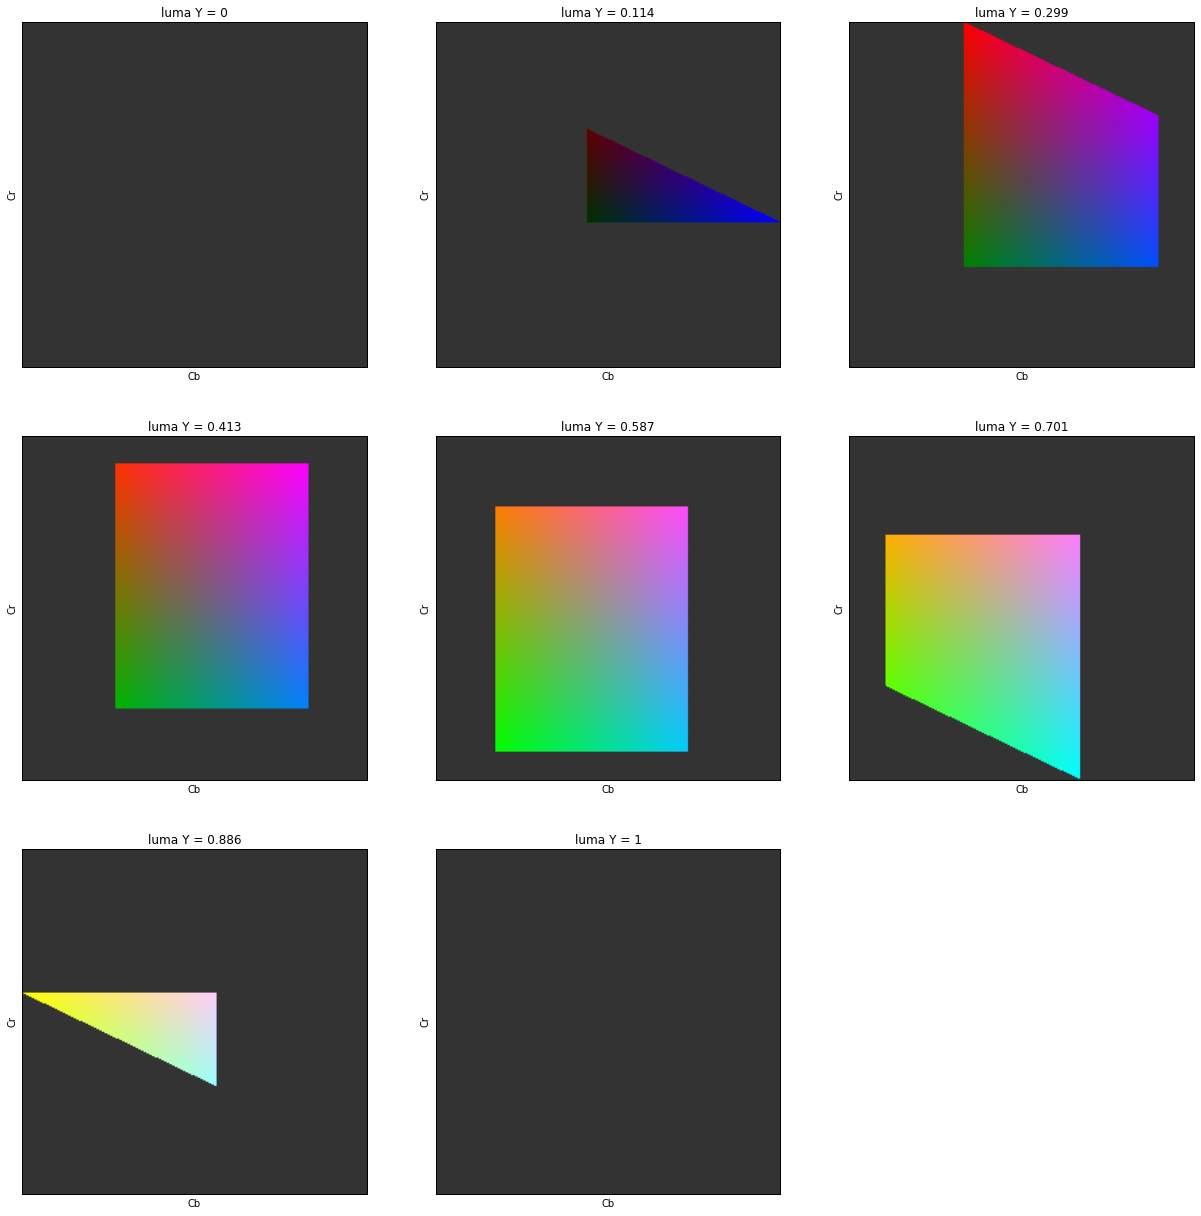

In [10]:
figure(figsize(21,21))
i = 0
for color_plane in color_planes:
    plt.subplot(3, 3, i+1), plt.imshow(color_plane)
    plt.xticks([]), plt.yticks([])
    plt.xlabel('Cb'), plt.ylabel('Cr')
    plt.title('luma Y = {0}'.format(lumas[i]))
    i += 1

### Valid Cb-Cr planes for Y values from 0 to 1

In [9]:
HTML("""
<video src='colorplane.mp4' loop autoplay controls width='256' height='256' type='video/mp4'></video>
""")

## Separation of the Y, Cr, and Cb channel: example 1

In [11]:
img = plt.imread('rgb_circles.jpg').astype(float32) / 255
ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

In [12]:
def print_range(a, s):
    amin = min(a.flatten())
    amax = max(a.flatten())
    print ('{0} has values in the range from {1} to {2}'.format(s, amin, amax))
    return amin, amax

In [13]:
print_range(img[0], 'R')
print_range(img[1], 'G')
print_range(img[2], 'B')
print_range(ycrcb[0], 'Y')
print_range(ycrcb[1], 'Cr')
print_range(ycrcb[2], 'Cb')

R has values in the range from 0.0 to 1.0
G has values in the range from 0.0 to 1.0
B has values in the range from 0.0 to 1.0
Y has values in the range from 0.0 to 0.9958928823471069
Cr has values in the range from 0.0 to 0.9985380172729492
Cb has values in the range from 0.0 to 0.9981716871261597


(0.0, 0.99817169)

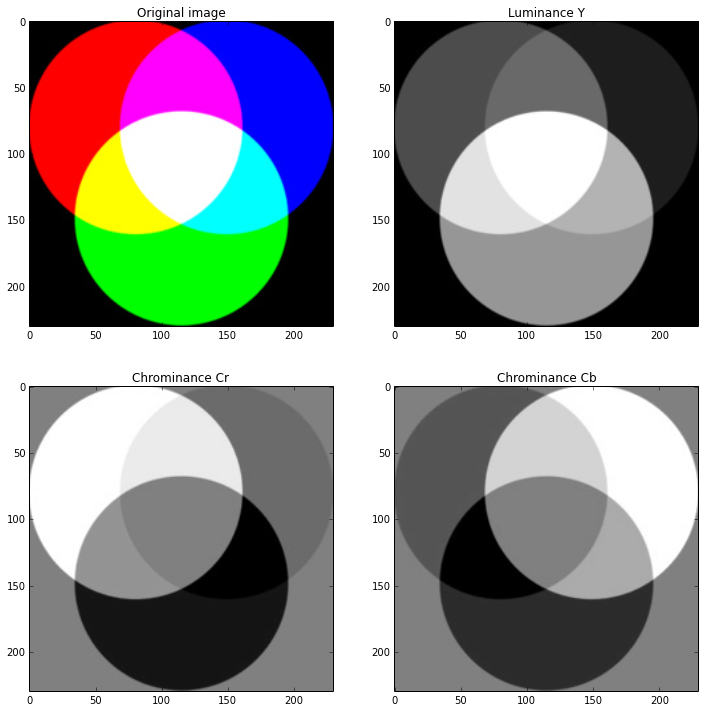

In [15]:
figure(figsize(12,12))
plt.subplot(2,2,1), plt.imshow(img), plt.title('Original image')
plt.subplot(2,2,2), plt.imshow(ycrcb[:,:,0], 'gray', vmin=0, vmax=1), plt.title('Luminance Y')
plt.subplot(2,2,3), plt.imshow(ycrcb[:,:,1], 'gray', vmin=0, vmax=1), plt.title('Chrominance Cr')
plt.subplot(2,2,4), plt.imshow(ycrcb[:,:,2], 'gray', vmin=0, vmax=1), plt.title('Chrominance Cb');

### Exercise

Identify all 8 colors (black, blue, red, magenta, green, cyan, yellow, and white) based on their Y, Cr, and Cb values in the Cb-Cr plane for the corresponding Y value.

## Separation of the Y, Cr, and Cb channel: example 2

Image from https://commons.wikimedia.org/wiki/File:Barns_grand_tetons.jpg

In [16]:
img2 = plt.imread('landscape.jpg').astype(float32) / 255
ycrcb2 = cv2.cvtColor(img2, cv2.COLOR_RGB2YCrCb)

In [17]:
print_range(img2[:,:,0], 'R');
print_range(img2[:,:,1], 'G');
print_range(img2[:,:,2], 'B');

R has values in the range from 0.0 to 1.0
G has values in the range from 0.0 to 1.0
B has values in the range from 0.0 to 1.0


In [18]:
print_range(ycrcb2[:,:,0], 'Y');
print_range(ycrcb2[:,:,1], 'Cr');
print_range(ycrcb2[:,:,2], 'Cb');

Y has values in the range from 0.0 to 1.0
Cr has values in the range from 0.374347001314 to 0.746077299118
Cb has values in the range from 0.166518956423 to 0.712616920471


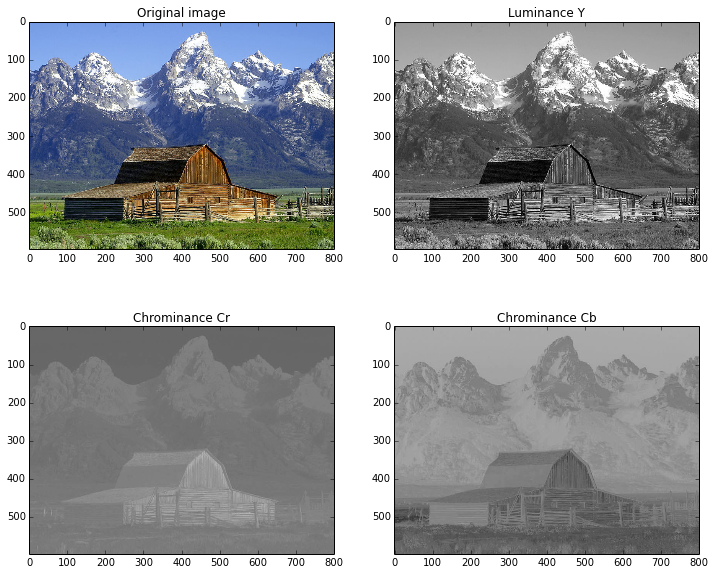

In [19]:
figure(figsize(12,10))
plt.subplot(2,2,1), plt.imshow(img2), plt.title('Original image')
plt.subplot(2,2,2), plt.imshow(ycrcb2[:,:,0], 'gray', vmin=0, vmax=1), plt.title('Luminance Y')
plt.subplot(2,2,3), plt.imshow(ycrcb2[:,:,1], 'gray', vmin=0, vmax=1), plt.title('Chrominance Cr')
plt.subplot(2,2,4), plt.imshow(ycrcb2[:,:,2], 'gray', vmin=0, vmax=1), plt.title('Chrominance Cb');

### Visualization of the three YCbCr channels in the RGB space

#### Convert each YCbCr channel to the RGB space

In [20]:
def channel2rgb(img_ycrcb, keep_channel):
    tmp = img_ycrcb.copy()
    for channel in range(3):
        if channel != keep_channel:
            tmp[:,:,channel] = 0.5
    return cv2.cvtColor(tmp, cv2.COLOR_YCrCb2RGB)

In [21]:
img2_y = channel2rgb(ycrcb2, 0)
img2_cr = channel2rgb(ycrcb2, 1)
img2_cb = channel2rgb(ycrcb2, 2)

#### Sanity check: reconstruct the original image from these three RGB images

$$
\begin{eqnarray*}
  \begin{pmatrix}
    R \\ G \\ B
  \end{pmatrix}
  &=&
  \begin{pmatrix}
    1 &  1.403 &  0 \\
    1 & -0.714 & -0.344 \\
    1 &  0     &  1.773
  \end{pmatrix}
  \cdot
  \left(
  \begin{pmatrix}
  Y \\ 0.5 - 0.5 \\ 0.5 - 0.5
  \end{pmatrix}
  +
  \begin{pmatrix}
  0.5 \\ C_r - 0.5 \\ 0.5 - 0.5
  \end{pmatrix}
  +
  \begin{pmatrix}
  0.5 \\ 0.5 - 0.5 \\ C_b - 0.5
  \end{pmatrix}
  \right) \\
  &=&
  \begin{pmatrix}
    1 &  1.403 &  0 \\
    1 & -0.714 & -0.344 \\
    1 &  0     &  1.773
  \end{pmatrix}
  \cdot
  \left(
  \begin{pmatrix}
  Y \\ C_r - 0.5 \\ C_b - 0.5
  \end{pmatrix}
  +
  \begin{pmatrix}
    1 \\ 0 \\ 0
  \end{pmatrix}
  \right) \\
  &=&
  \begin{pmatrix}
    1 &  1.403 &  0 \\
    1 & -0.714 & -0.344 \\
    1 &  0     &  1.773
  \end{pmatrix}
  \cdot
  \begin{pmatrix}
    Y \\ C_r - 0.5 \\ C_b - 0.5
  \end{pmatrix}
  \quad + \quad
  \begin{pmatrix}
    1 \\ 1 \\ 1
  \end{pmatrix}  
\end{eqnarray*}
$$

In [22]:
img_recon = img2_y + img2_cr + img2_cb

In [23]:
img_recon[:,:,0] -= 1.0
img_recon[:,:,1] -= 1.0
img_recon[:,:,2] -= 1.0

In [24]:
print_range(img_recon[:,:,0], 'R')
print_range(img_recon[:,:,1], 'G')
print_range(img_recon[:,:,2], 'B');

R has values in the range from -3.48091125488e-05 to 1.00009822845
G has values in the range from 0.0 to 1.0
B has values in the range from 0.0 to 1.0


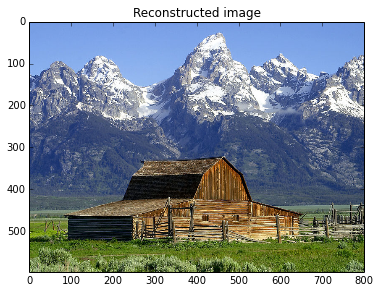

In [25]:
figure(figsize(6,5))
plt.imshow(img_recon), plt.title('Reconstructed image');

#### Check the range of the three RGB images

In [26]:
print_range(img2_y[:,:,0], 'R');
print_range(img2_y[:,:,1], 'G');
print_range(img2_y[:,:,2], 'B');

R has values in the range from 0.0 to 1.0
G has values in the range from 0.0 to 1.0
B has values in the range from 0.0 to 1.0


In [27]:
print_range(img2_cr[:,:,0], 'R');
print_range(img2_cr[:,:,1], 'G');
print_range(img2_cr[:,:,2], 'B');

R has values in the range from 0.323708832264 to 0.845246434212
G has values in the range from 0.324300825596 to 0.589716255665
B has values in the range from 0.5 to 0.5


In [28]:
print_range(img2_cb[:,:,0], 'R');
print_range(img2_cb[:,:,1], 'G');
print_range(img2_cb[:,:,2], 'B');

R has values in the range from 0.5 to 0.5
G has values in the range from 0.426859766245 to 0.614717483521
B has values in the range from -0.0912618637085 to 0.876969814301


<span style="color:red">WARNING: RGB values out of range!</span><br>

#### Attempts to visualize the channels albeit the invalid RGB values

##### Attempt 1: normalize the intensity range

Normalization shows all the information but changes the colors.

In [29]:
def norm(img, minimum=0, maximum=1):
    img_min = min(img.flatten())
    img_max = max(img.flatten())
    return (img - img_min) / (img_max - img_min)

##### Attempt 2: crop the image intensities

Cropping loses information but does not change the colors.

In [30]:
def crop(img, minimum=0, maximum=1):
    tmp = np.where(img > maximum, maximum, img)
    tmp = np.where(tmp < minimum, minimum, tmp)
    return tmp

Note: if you normalize the images, channels that do not carry any information should not influence the normalization. In this example, this is not a problem since the B channel of img2_cr and the R channel of img2_c are constant at 0.5 and not out-of-range.

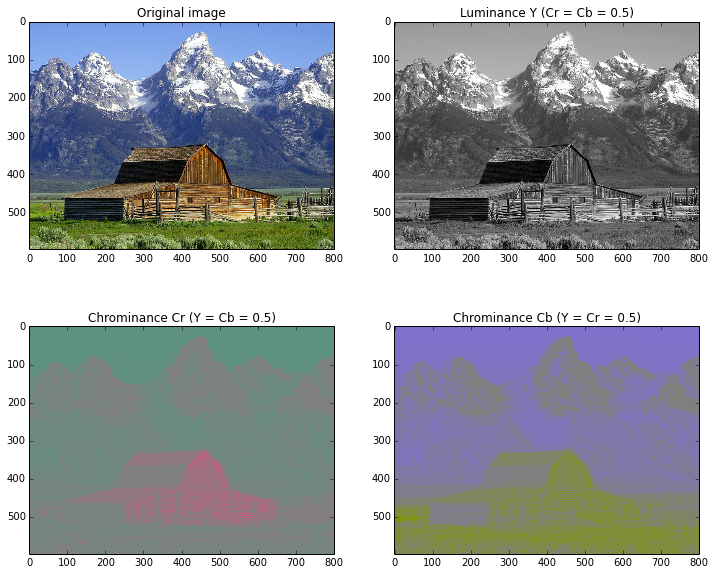

In [31]:
figure(figsize(12,10))
plt.subplot(2,2,1), plt.imshow(img2), plt.title('Original image')
plt.subplot(2,2,2), plt.imshow(crop(img2_y)), plt.title('Luminance Y (Cr = Cb = 0.5)');
plt.subplot(2,2,3), plt.imshow(crop(img2_cr)), plt.title('Chrominance Cr (Y = Cb = 0.5)')
plt.subplot(2,2,4), plt.imshow(crop(img2_cb)), plt.title('Chrominance Cb (Y = Cr = 0.5)');